In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import requests
import json
from sklearn.preprocessing import LabelEncoder

In [2]:
#creating a DF out of the entire csv
births_df = pd.read_csv("resources/2021_Data.csv")
births_df.head()

,dob_yy,dob_mm,dob_tt,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,mager14,...,ca_downs,ca_disor,ca_hypo,f_ca_limb,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen
0,2021,1,636,1,1,1,NaN,NaN,22,8,...,N,N,N,1,1,1,1,1,1,1
1,2021,1,259,1,1,1,NaN,NaN,31,10,...,N,N,N,1,1,1,1,1,1,1
2,2021,1,223,1,1,1,NaN,NaN,29,9,...,N,N,N,1,1,1,1,1,1,1
3,2021,1,241,1,1,1,NaN,NaN,39,11,...,N,N,N,1,1,1,1,1,1,1
4,2021,1,503,1,1,1,NaN,NaN,20,8,...,N,N,N,1,1,1,1,1,1,1


# Data Cleaning: (Emily)

In [3]:
#choosing columns i want to examine more
clean_births_df = births_df[["dob_yy", "dob_mm","bfacil", "mager", "bmi_r", "priorlive", "priordead", "precare", "previs", "ld_anes", "attend","mm_aicu", "ab_nicu", "pay", "dbwt"]]
clean_births_df.head()

,dob_yy,dob_mm,bfacil,mager,bmi_r,priorlive,priordead,precare,previs,ld_anes,attend,mm_aicu,ab_nicu,pay,dbwt
0,2021,1,1,22,2,0,0,3,99,Y,1,N,N,5,3670
1,2021,1,1,31,3,1,0,99,99,Y,1,N,N,6,3210
2,2021,1,1,29,2,1,0,3,8,N,3,N,N,2,3997
3,2021,1,1,39,2,0,0,2,10,Y,2,N,N,1,3510
4,2021,1,1,20,2,0,0,3,11,N,1,N,N,1,3100


In [4]:
#rename columns 
clean_births_df = clean_births_df.rename(columns={"dob_yy":"Birth Year", "dob_mm":"Birth Month", 
                                                  "bfacil":"Birth Place", "mager":"Mother's Age", "bmi_r":"Mother's BMI",
                                                  "priorlive":"Living Children", "priordead":"Deceased Children",
                                                 "precare": "Prenatal Care", "previs": "# of Prenatal Visits",
                                                  "ld_anes": "Used Anesthesia", "attend":"Attendant at Birth",
                                                  "mm_aicu":"Intensive Care Admission", "ab_nicu": "NICU Admission", 
                                                  "pay":"Payment Source", "dbwt":"Birth Weight",
                                                 })
clean_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight
0,2021,1,1,22,2,0,0,3,99,Y,1,N,N,5,3670
1,2021,1,1,31,3,1,0,99,99,Y,1,N,N,6,3210
2,2021,1,1,29,2,1,0,3,8,N,3,N,N,2,3997
3,2021,1,1,39,2,0,0,2,10,Y,2,N,N,1,3510
4,2021,1,1,20,2,0,0,3,11,N,1,N,N,1,3100


In [5]:
#Filtering out any data that is unknown (this is represented by the values 9 and/or 99)
clean_births_df = clean_births_df[~clean_births_df.apply(lambda row: any(x in [9, 99] for x in row), axis=1)]

In [6]:
clean_births_df.dtypes

Birth Year                   int64
Birth Month                  int64
Birth Place                  int64
Mother's Age                 int64
Mother's BMI                 int64
Living Children              int64
Deceased Children            int64
Prenatal Care                int64
# of Prenatal Visits         int64
Used Anesthesia             object
Attendant at Birth           int64
Intensive Care Admission    object
NICU Admission              object
Payment Source               int64
Birth Weight                 int64
dtype: object

In [7]:
#declaring recoding responses as objects to later replace with coded meaning
clean_births_df = clean_births_df.astype({"Birth Place":str}, errors='raise')
clean_births_df = clean_births_df.astype({"Mother's BMI":str}, errors='raise')
clean_births_df = clean_births_df.astype({"Attendant at Birth": str}, errors='raise')
clean_births_df = clean_births_df.astype({"Payment Source": str}, errors='raise')

In [8]:
#verify datatypes were changed
clean_births_df.dtypes

Birth Year                   int64
Birth Month                  int64
Birth Place                 object
Mother's Age                 int64
Mother's BMI                object
Living Children              int64
Deceased Children            int64
Prenatal Care                int64
# of Prenatal Visits         int64
Used Anesthesia             object
Attendant at Birth          object
Intensive Care Admission    object
NICU Admission              object
Payment Source              object
Birth Weight                 int64
dtype: object

In [9]:
#decoding inputs based on documentation
#OK if returns a warning. 
#If returns an error- restart and run all

##For column: Birth place
clean_births_df["Birth Place"] = clean_births_df["Birth Place"].replace({"1":"Hospital", "2": "Freestanding Birth Center",
                                                                         "3":"Home (intended)", "4": "Home (unintended)",
                                                                        "5": "Home (intent unknown)", "6": "Clinic/Doctor's Office",
                                                                        "7":"Other",
                                                                        })
##For column: Mother's BMI
clean_births_df["Mother's BMI"] = clean_births_df["Mother's BMI"].replace({"1":"Underweight <18.5", "2":"Normal 18.5-24.9",
                                                                          "3": "Overweight 25.0-29.9", "4":"Obesity I 35.0-34.9",
                                                                          "5":"Obesity II 35.0-39.9", "6": "Extreme Obesity III ≥ 40.0",
                                                                          })
##For column: Prenatal Care
clean_births_df.loc[(clean_births_df['Prenatal Care'] >= 1) & (clean_births_df['Prenatal Care'] <= 10), 'Prenatal Care'] = 'Y'
clean_births_df.loc[(clean_births_df['Prenatal Care'] == 0), 'Prenatal Care'] = 'N'


##For column: Attendant at Birth
clean_births_df["Attendant at Birth"] = clean_births_df["Attendant at Birth"].replace({"1": "Doctor of Medicine (MD)", "2": "Doctor of Osteopathy (DO)",
                                                                                      "3":"Certified Nurse Midwife/Certified Midwife (CNM/CM)", "4":"Other Midwife",
                                                                                      "5": "Other",
                                                                                      })
##For column: Payment Source
clean_births_df["Payment Source"] = clean_births_df["Payment Source"].replace({"1":"Medicaid", "2":"Private Insurance",
                                                                              "3": "Self-Pay", "4":"Indian Health Service",
                                                                              "5":"CHAMPUS/TRICARE", "6":"Other Government (Federal, State, Local)",
                                                                              "8":"Other"})

#Show updated dataframe
clean_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight
2,2021,1,Hospital,29,Normal 18.5-24.9,1,0,Y,8,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,3997
3,2021,1,Hospital,39,Normal 18.5-24.9,0,0,Y,10,Y,Doctor of Osteopathy (DO),N,N,Medicaid,3510
4,2021,1,Hospital,20,Normal 18.5-24.9,0,0,Y,11,N,Doctor of Medicine (MD),N,N,Medicaid,3100
5,2021,1,Hospital,29,Obesity II 35.0-39.9,0,0,Y,7,Y,Doctor of Medicine (MD),N,N,Private Insurance,3300
7,2021,1,Hospital,34,Normal 18.5-24.9,6,0,Y,11,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,3495


In [10]:
#convert baby birth weight from grams to pounds

# Conversion factor from grams to pounds
grams_to_pounds_conversion_factor = 0.00220462

clean_births_df["Birth Weight"] = clean_births_df["Birth Weight"] * grams_to_pounds_conversion_factor

#Rename column 
clean_births_df = clean_births_df.rename(columns={"Birth Weight":"Birth Weight (lbs)"})

#display 
clean_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight (lbs)
2,2021,1,Hospital,29,Normal 18.5-24.9,1,0,Y,8,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,8.811866
3,2021,1,Hospital,39,Normal 18.5-24.9,0,0,Y,10,Y,Doctor of Osteopathy (DO),N,N,Medicaid,7.738216
4,2021,1,Hospital,20,Normal 18.5-24.9,0,0,Y,11,N,Doctor of Medicine (MD),N,N,Medicaid,6.834322
5,2021,1,Hospital,29,Obesity II 35.0-39.9,0,0,Y,7,Y,Doctor of Medicine (MD),N,N,Private Insurance,7.275246
7,2021,1,Hospital,34,Normal 18.5-24.9,6,0,Y,11,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,7.705147


### Baby Birth Weight Analysis: (Emily)

In [11]:
#create simplified dataframe

weight_df = clean_births_df[["Birth Weight (lbs)","Payment Source"]]
weight_df.head()

,Birth Weight (lbs),Payment Source
2,8.811866,Private Insurance
3,7.738216,Medicaid
4,6.834322,Medicaid
5,7.275246,Private Insurance
7,7.705147,Private Insurance


In [12]:
#name variables i want to compare
weight = weight_df["Birth Weight (lbs)"]
payment = weight_df["Payment Source"]

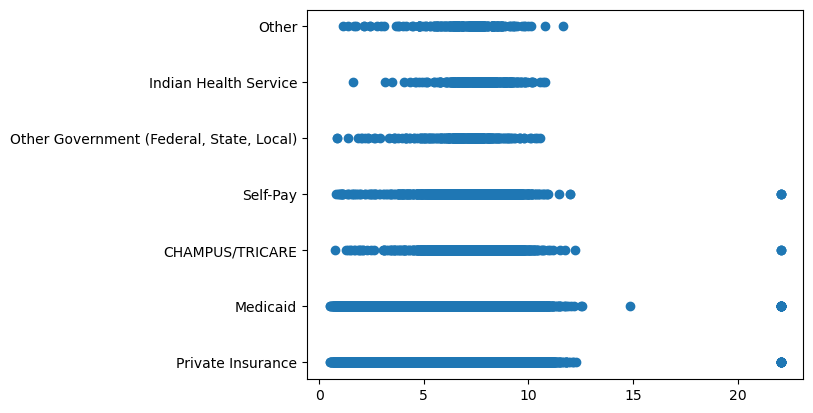

In [13]:
#test out what scatter plot looks like
plt.scatter(weight, payment)

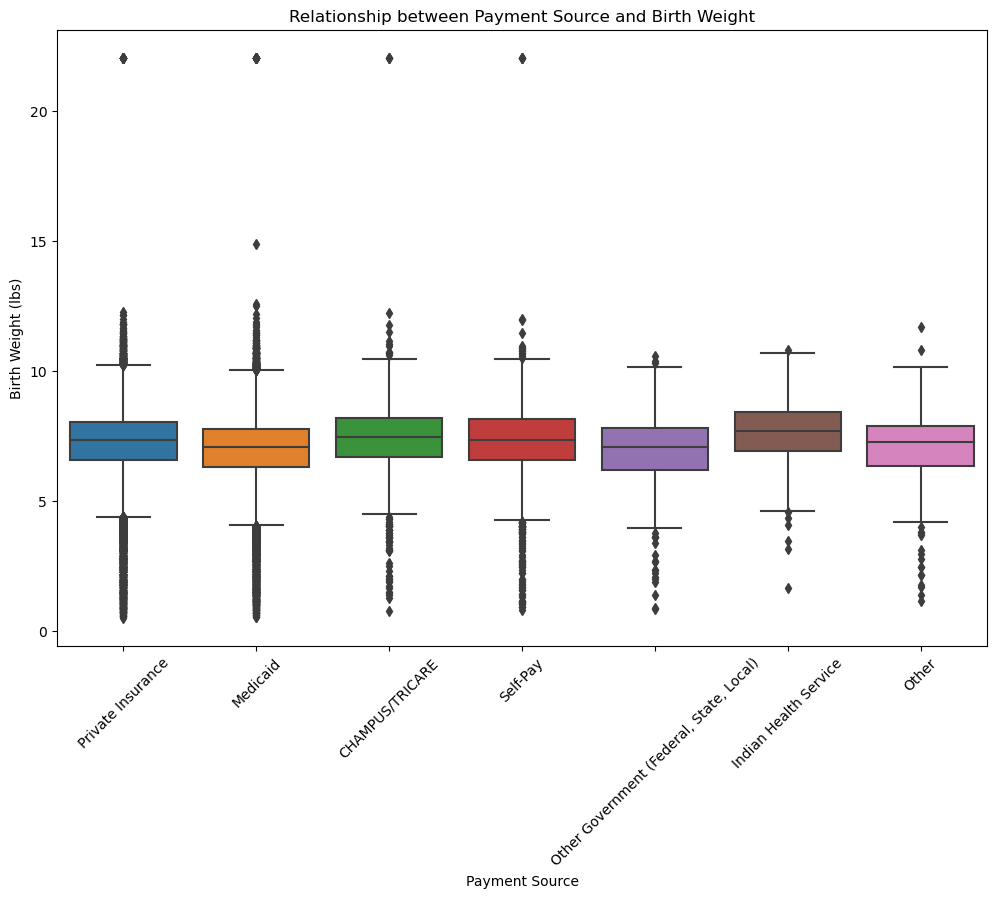

In [14]:
# Create a box plot for a better comparison view 

plt.figure(figsize=(12, 8))
sns.boxplot(x='Payment Source', y='Birth Weight (lbs)', data=clean_births_df)
plt.title('Relationship between Payment Source and Birth Weight')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Save the figure
plt.savefig("visuals/weight_payment.png")
plt.show()

### Attending Physician Analysis (Emily)

In [15]:
# Filter data for only Private Insurance and Medicaid
private_insurance_data = clean_births_df[clean_births_df['Payment Source'] == 'Private Insurance']
medicaid_data = clean_births_df[clean_births_df['Payment Source'] == 'Medicaid']

In [16]:
# Calculate the proportion of Doctor of Medicine (MD) attendants for each group
private_insurance_md_proportion = private_insurance_data['Attendant at Birth'].value_counts(normalize=True).get('Doctor of Medicine (MD)', 0)
medicaid_md_proportion = medicaid_data['Attendant at Birth'].value_counts(normalize=True).get('Doctor of Medicine (MD)', 0)

print("Proportion of MD attendants for Private Insurance:", private_insurance_md_proportion)
print("Proportion of MD attendants for Medicaid:", medicaid_md_proportion)


Proportion of MD attendants for Private Insurance: 0.9093452290942083
Proportion of MD attendants for Medicaid: 0.8923965080259082


In [17]:
# Create a contingency table
contingency_table = pd.crosstab(clean_births_df['Payment Source'], clean_births_df['Attendant at Birth'])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-square value:", chi2)
print("P-value:", p)

Chi-square value: 14110.412371547129
P-value: 0.0


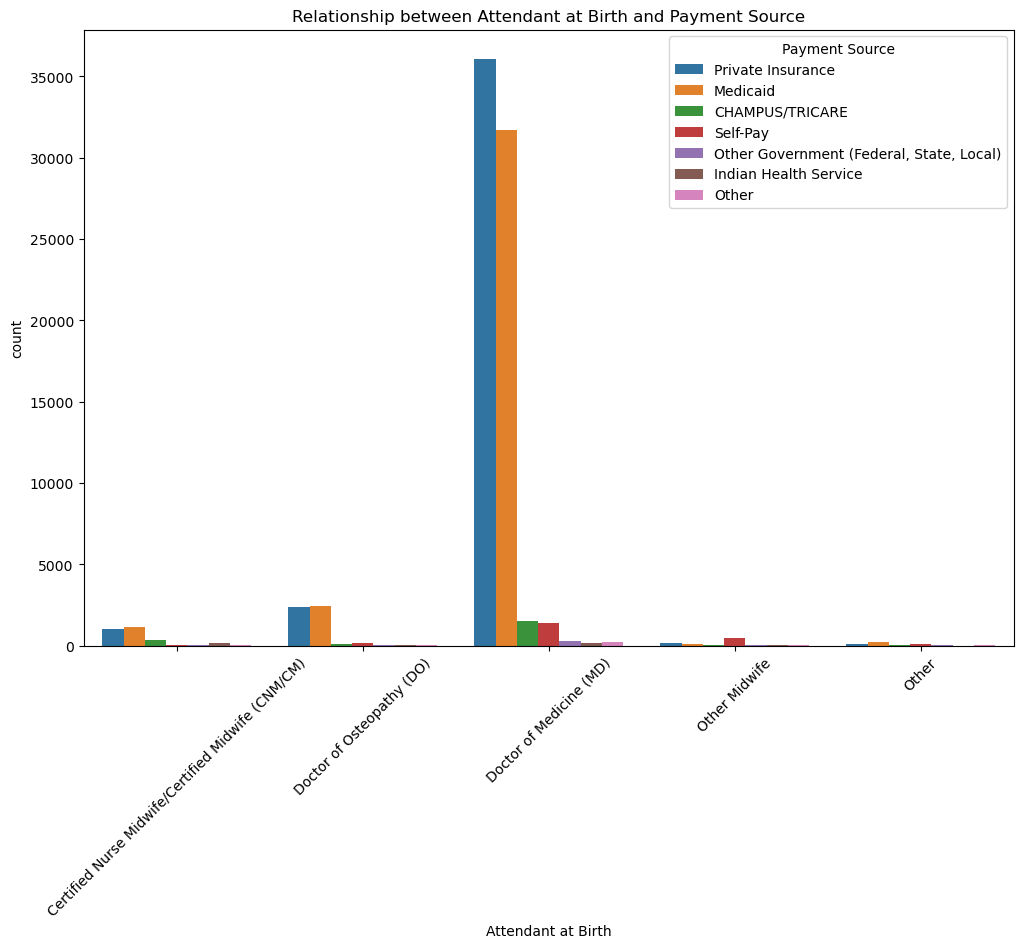

In [18]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Attendant at Birth', hue='Payment Source', data=clean_births_df)
plt.title('Relationship between Attendant at Birth and Payment Source')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Payment Source', bbox_to_anchor=(1, 1))  # Add legend for Payment Source
# Save the figure
plt.savefig("visuals/attending_payment.png")
plt.show()

### Anesthesia Analysis: (Emily)

In [19]:
#calculating proportions 
private_insurance_data = clean_births_df[clean_births_df['Payment Source'] == 'Private Insurance']
medicaid_data = clean_births_df[clean_births_df['Payment Source'] == 'Medicaid']

private_insurance_anesthesia_proportion = private_insurance_data['Used Anesthesia'].value_counts(normalize=True).get('Y', 0)
medicaid_anesthesia_proportion = medicaid_data['Used Anesthesia'].value_counts(normalize=True).get('Y', 0)

print("Proportion using Anesthesia for Medicaid:", medicaid_anesthesia_proportion)
print("Proportion using Anesthesia for Private Insurance:", private_insurance_anesthesia_proportion)

Proportion using Anesthesia for Medicaid: 0.7901436215150662
Proportion using Anesthesia for Private Insurance: 0.8500428449014568


In [20]:
# Create a contingency table
contingency_table = pd.crosstab(clean_births_df['Payment Source'], clean_births_df['Used Anesthesia'])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-square value:", chi2)
print("P-value:", p)

Chi-square value: 1897.5493731238273
P-value: 0.0


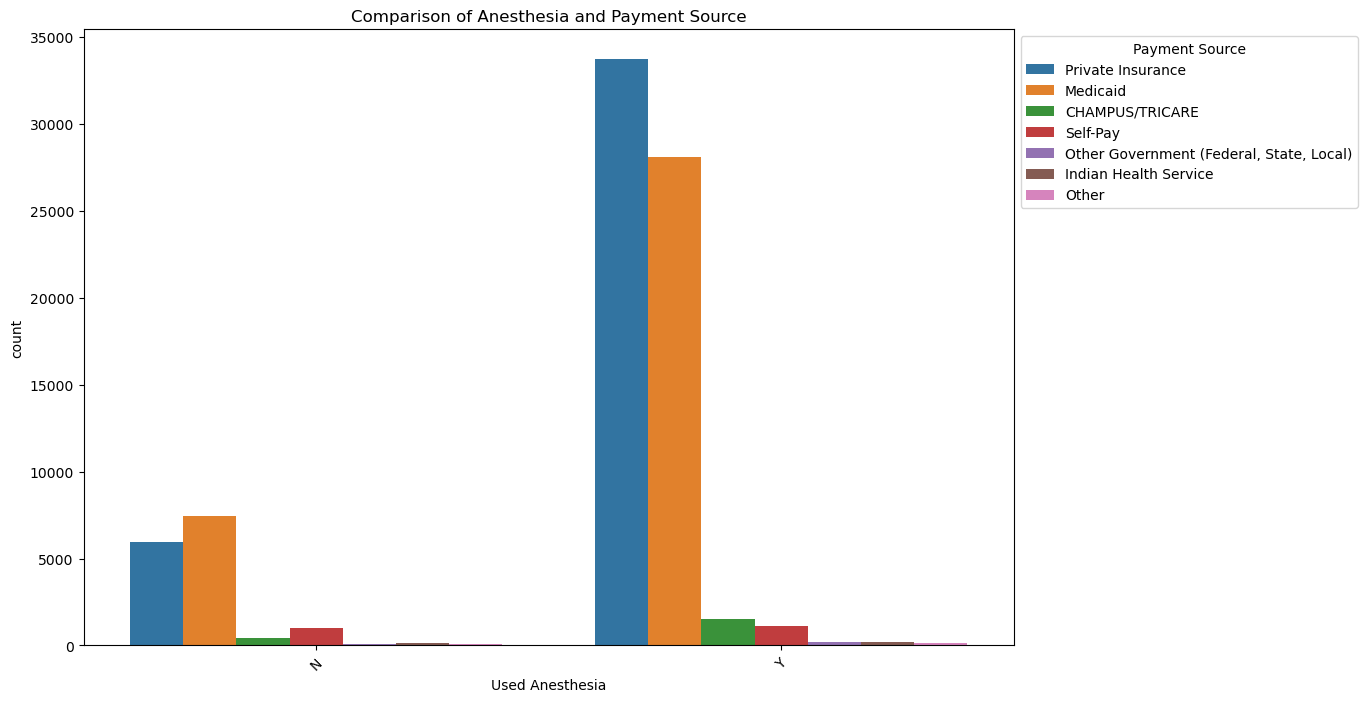

In [21]:
# Filter out rows with 'unknown' values in both columns
filtered_df = clean_births_df[(clean_births_df['Used Anesthesia'] != 'U') & (clean_births_df['Payment Source'] != 'U')]

# Create a count plot or stacked bar plot
plt.figure(figsize=(12, 8))
sns.countplot(x='Used Anesthesia', hue='Payment Source', data=filtered_df)
plt.title('Comparison of Anesthesia and Payment Source')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Payment Source', bbox_to_anchor=(1, 1))  # Add legend for Payment Source
plt.savefig("visuals/anesthesia_payment.png")
plt.show()

### NICU Analysis (Emily)

In [22]:
#calculating proportions 
private_insurance_data = clean_births_df[clean_births_df['Payment Source'] == 'Private Insurance']
medicaid_data = clean_births_df[clean_births_df['Payment Source'] == 'Medicaid']

private_NICU_proportion = private_insurance_data['NICU Admission'].value_counts(normalize=True).get('Y', 0)
medicaid_NICU_proportion = medicaid_data['NICU Admission'].value_counts(normalize=True).get('Y', 0)

print("Proportion NICU Admission for Medicaid:", medicaid_NICU_proportion)
print("Proportion NICU Admission for Private Insurance:", private_NICU_proportion)

Proportion NICU Admission for Medicaid: 0.09521261616446071
Proportion NICU Admission for Private Insurance: 0.09584656484701849


In [23]:
# Create a contingency table
contingency_table = pd.crosstab(clean_births_df['Payment Source'], clean_births_df['NICU Admission'])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-square value:", chi2)
print("P-value:", p)

Chi-square value: 199.67953060593965
P-value: 3.7979939950468425e-36


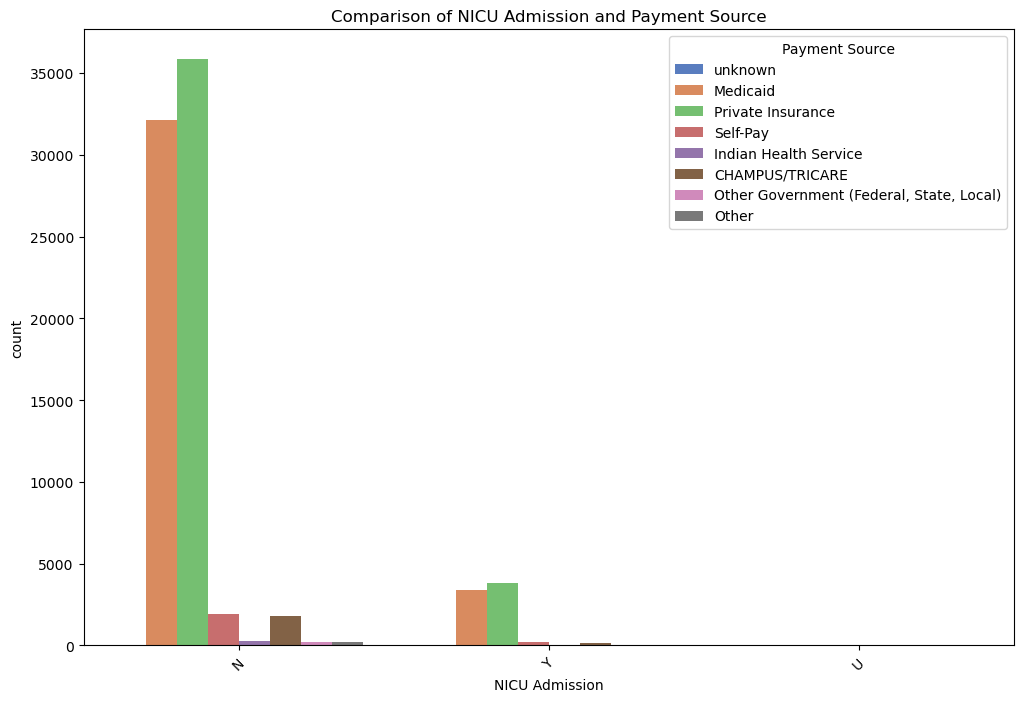

In [24]:
plt.figure(figsize=(12, 8))
sns.countplot(x='NICU Admission', hue='Payment Source', data=clean_births_df, palette='muted', hue_order=['unknown', 'Medicaid', 'Private Insurance', 'Self-Pay', 'Indian Health Service', 'CHAMPUS/TRICARE', 'Other Government (Federal, State, Local)', 'Other'])
plt.title('Comparison of NICU Admission and Payment Source')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Payment Source', bbox_to_anchor=(1, 1))  # Add legend for Payment Source
plt.savefig("visuals/nicu_payment.png")
plt.show()

# Data Cleaning (Anthony)

In [25]:
# Extract columns related to Prenatal Care + Payment Source

precare_births_df = births_df[["dob_yy", "dob_mm","bfacil", "mager", "precare", "previs", "wic", "pay_rec"]]
precare_births_df.head()

,dob_yy,dob_mm,bfacil,mager,precare,previs,wic,pay_rec
0,2021,1,1,22,3,99,Y,4
1,2021,1,1,31,99,99,N,4
2,2021,1,1,29,3,8,N,2
3,2021,1,1,39,2,10,N,1
4,2021,1,1,20,3,11,N,1


In [26]:
# Rename columns

precare_births_df = precare_births_df.rename(columns={
    "dob_yy":"Birth Year", 
    "dob_mm":"Birth Month", 
    "bfacil":"Birth Place", 
    "mager":"Mother's Age", 
    "precare": "Month Prenatal Care Began", 
    "previs": "Number of Prenatal Visits",
    "wic": "WIC",
    "pay_rec":"Payment Source",
})
precare_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Month Prenatal Care Began,Number of Prenatal Visits,WIC,Payment Source
0,2021,1,1,22,3,99,Y,4
1,2021,1,1,31,99,99,N,4
2,2021,1,1,29,3,8,N,2
3,2021,1,1,39,2,10,N,1
4,2021,1,1,20,3,11,N,1


In [27]:
# Filtering out any data that is unknown (this is represented by the values 9 and/or 99)

precare_births_df = precare_births_df[~precare_births_df.apply(lambda row: any(x in [9,99] for x in row), axis=1)]
precare_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Month Prenatal Care Began,Number of Prenatal Visits,WIC,Payment Source
2,2021,1,1,29,3,8,N,2
3,2021,1,1,39,2,10,N,1
4,2021,1,1,20,3,11,N,1
5,2021,1,1,29,3,7,N,2
6,2021,1,1,23,3,17,N,1


In [28]:
# Convert columns to strings
precare_births_df["Birth Place"] = precare_births_df["Birth Place"].astype(str)
precare_births_df["Payment Source"] = precare_births_df["Payment Source"].astype(str)
precare_births_df["Birth Month"] = precare_births_df["Birth Month"].astype(str)

# Replace values
precare_births_df["Birth Place"] = precare_births_df["Birth Place"].replace({"1": "Hospital", "2": "Freestanding Birth Center", "3": "Home (intended)", "4": "Home (unintended)", "5": "Home (intent unknown)", "6": "Clinic/Doctor's Office", "7": "Other"})
precare_births_df["Payment Source"] = precare_births_df["Payment Source"].replace({"1": "Medicaid", "2": "Private Insurance", "3": "Self-Pay", "4": "Other", "9": "Unknown"})
precare_births_df["Birth Month"] = precare_births_df["Birth Month"].replace({"1": "Jan", "2": "Feb", "3": "Mar", "4": "Apr", "5": "May", "6": "Jun", "7": "Jul", "8": "Aug", "9": "Sep", "10":"Oct", "11":"Nov", "12":"Dec"})


# Display updated dataframe
precare_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Month Prenatal Care Began,Number of Prenatal Visits,WIC,Payment Source
2,2021,Jan,Hospital,29,3,8,N,Private Insurance
3,2021,Jan,Hospital,39,2,10,N,Medicaid
4,2021,Jan,Hospital,20,3,11,N,Medicaid
5,2021,Jan,Hospital,29,3,7,N,Private Insurance
6,2021,Jan,Hospital,23,3,17,N,Medicaid


In [29]:
for column in precare_births_df.columns:
    unique_values = precare_births_df[column].unique()
    print(f"{column}: {unique_values}")

Birth Year: [2021]
Birth Month: ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Oct' 'Nov' 'Dec']
Birth Place: ['Hospital' 'Freestanding Birth Center' 'Home (intended)'
 "Clinic/Doctor's Office" 'Home (intent unknown)' 'Home (unintended)'
 'Other']
Mother's Age: [29 39 20 23 34 19 25 24 28 32 37 27 41 36 38 33 21 31 22 30 35 26 48 40
 18 16 42 17 15 44 43 14 45 47 46 13 12 50 49]
Month Prenatal Care Began: [ 3  2  5  1  6  7  4  8  0 10]
Number of Prenatal Visits: [ 8 10 11  7 17  5 19  3 12  4 15 14 25  2 13  6 27 18 16  1 22 20 21  0
 26 24 28 35 29 23 39 34 46 41 33 30 32 31 38 42 37]
WIC: ['N' 'Y' 'U']
Payment Source: ['Private Insurance' 'Medicaid' 'Other' 'Self-Pay']


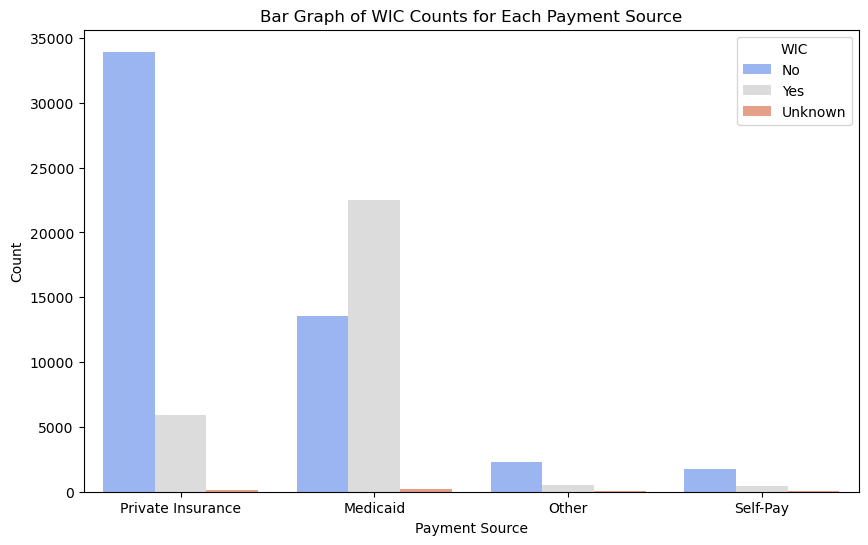

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'Y', 'N', 'U' in 'WIC' column with categorical values
precare_births_df['WIC'] = precare_births_df['WIC'].replace({'Y': 'Yes', 'N': 'No', 'U': 'Unknown'})

# Create a bar graph
plt.figure(figsize=(10, 6))
sns.countplot(x='Payment Source', hue='WIC', data=precare_births_df, palette='coolwarm')
plt.title('Bar Graph of WIC Counts for Each Payment Source')
plt.xlabel('Payment Source')
plt.ylabel('Count')
plt.legend(title='WIC')
plt.savefig('visuals/wic_payment_source_bar_graph.png')
plt.show()

# Daniel Analysis

Summary analysis: in fig 1 we can see that younger mothers come surprisingly from military personnel type of coverage.

Fig 2 breaks down and shows how people with government support have higher chances of having a lower than healthy baby

Fig 3 shows that surprisingly natives have higher rate of overweight babies, with military personnel following.

Finally, fig 4 breaks down higher and lower weight of babies based on the number of children the mother had, the more risk she has of having an underweight baby, but that is also because the women are older on average by the third child so that has the risks associated accordingly. However, it is worth noting that for the first child there seem to also be a higher rate of low weight births. 

In [31]:
#function to grab mean, median, and std_dev values from any given column in the dataframe
def perform_analysis(df, columns):

    analysis_df = df[columns]

    # Convert numeric columns to numeric data type with downcast, making sure to replace any non numbers with NaN
    #downcast converts the numeric value to the smallest one possible
    analysis_df = analysis_df.apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='float'))

    # Calculate mean, median, and standard deviation values
    mean_values = analysis_df.mean()
    median_values = analysis_df.median()
    std_dev_values = analysis_df.std()

    return mean_values, median_values, std_dev_values


In [32]:
columns_to_analyze = ["Mother's Age", "Payment Source"]

# Perform analysis
mean_values, median_values, std_dev_values = perform_analysis(clean_births_df, columns_to_analyze)

# Display results
print("Mean Values:")
print(mean_values)
print("\nMedian Values:")
print(median_values)
print("\nStandard Deviation Values:")
print(std_dev_values)

Mean Values:
Mother's Age      27.739426
Payment Source          NaN
dtype: float32

Median Values:
Mother's Age      28.0
Payment Source     NaN
dtype: float32

Standard Deviation Values:
Mother's Age      5.662805
Payment Source         NaN
dtype: float32


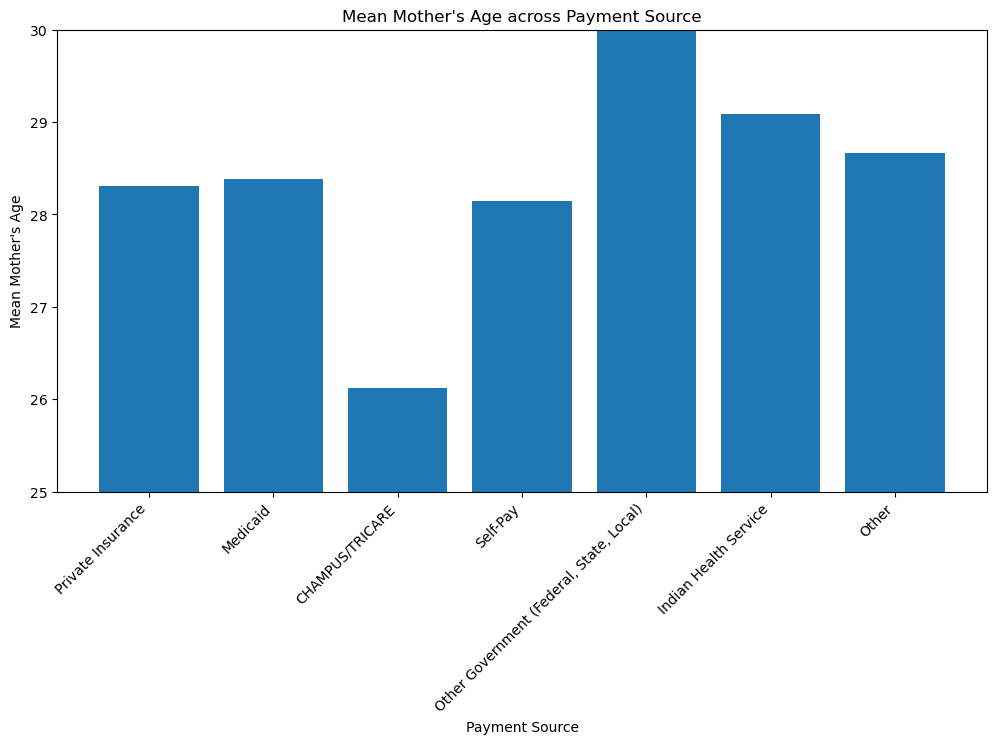

In [33]:
#plotting the mean age across payment source
plt.figure(figsize=(12, 6))
payment_source_values = clean_births_df['Payment Source'].unique()
mean_mother_age_values = clean_births_df.groupby('Payment Source')["Mother's Age"].mean()
plt.bar(payment_source_values, mean_mother_age_values)
plt.title("Mean Mother's Age across Payment Source")
plt.xlabel("Payment Source")
plt.ylabel("Mean Mother's Age")
plt.ylim(25, 30)  # Set Y-axis range from 25 to 30
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.savefig('visuals/mother_age_vs_payment_source.png')  # Save the plot as a PNG file
plt.show()#fig 1

In [34]:
# Find the maximum and minimum values of "Birth Weight (lbs)"
max_birth_weight = clean_births_df['Birth Weight (lbs)'].max()
min_birth_weight = clean_births_df['Birth Weight (lbs)'].min()

print(f"Maximum Birth Weight: {max_birth_weight} lbs")
print(f"Minimum Birth Weight: {min_birth_weight} lbs")

Maximum Birth Weight: 22.043995380000002 lbs
Minimum Birth Weight: 0.5004487400000001 lbs


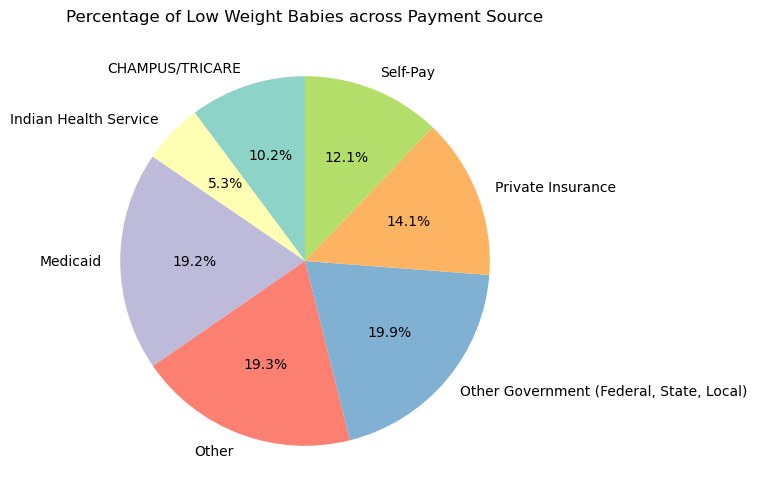

In [35]:
# Categorize babies into "low weight" and "high weight"
low_weight_threshold = 5
high_weight_threshold = 9

clean_births_df['Weight Category'] = pd.cut(clean_births_df['Birth Weight (lbs)'],
                                           bins=[-np.inf, low_weight_threshold, high_weight_threshold, np.inf],
                                           labels=['Low Weight', 'Normal Weight', 'High Weight'])

# Calculate the percentage of low-weight and high-weight babies in each payment source
weight_category_counts = clean_births_df[clean_births_df['Weight Category'] != 'Normal Weight']\
    .groupby(['Payment Source', 'Weight Category']).size().unstack()

weight_category_percentages = weight_category_counts.div(weight_category_counts.sum(axis=1), axis=0) * 100

# Plot the pie chart for Low Weight percentage
plt.figure(figsize=(12, 6))
labels = weight_category_percentages.index

colors_low_weight = plt.cm.Set3(np.arange(len(labels))) #makes sure each one gets a different color
plt.pie(weight_category_percentages['Low Weight'], 
        labels=labels, autopct='%1.1f%%', startangle=90, colors=colors_low_weight)
plt.title("Percentage of Low Weight Babies across Payment Source")
plt.savefig('visuals/percentage_low_weight_pie_chart.png')
plt.show() #fig 2

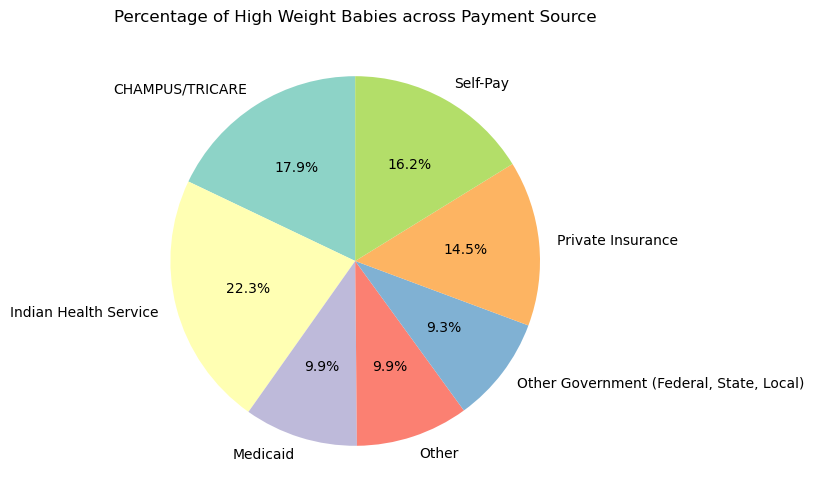

In [36]:
# Plot the pie chart for High Weight percentage
plt.figure(figsize=(12, 6))
labels = weight_category_percentages.index
colors_high_weight = plt.cm.Set3(np.arange(len(labels)))
plt.pie(weight_category_percentages['High Weight'], 
        labels=labels, autopct='%1.1f%%', startangle=90, colors=colors_high_weight)
plt.title("Percentage of High Weight Babies across Payment Source")
plt.savefig('visuals/percentage_high_weight_pie_chart.png')
plt.show()#fig 3

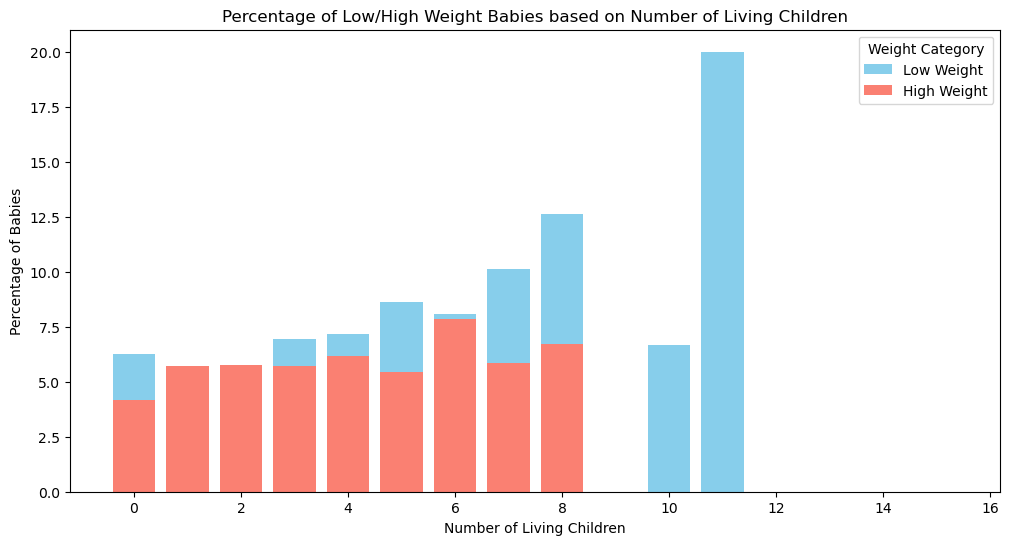

In [37]:
# Create a new DataFrame with relevant columns
child_weight_df = clean_births_df[['Living Children', 'Weight Category']]

# Group by 'Living Children' and 'Weight Category', calculate count, and unstack
child_weight_counts = child_weight_df.groupby(['Living Children', 'Weight Category']).size().unstack()

# Calculate the total number of babies for each number of living children
total_babies_per_child = child_weight_counts.sum(axis=1)

# Calculate the percentage of low-weight and high-weight babies for each number of living children
child_weight_percentages = child_weight_counts.div(total_babies_per_child, axis=0) * 100

# Plot the comparison between the number of living children and the percentage of low/high-weight babies
plt.figure(figsize=(12, 6))

# Set the color map for each weight category
colors = {'Low Weight': 'skyblue', 'High Weight': 'salmon'}

# Plot each bar for Low Weight and High Weight
#zero out the percentages making sure then length is equal to the amount of categories 
bottom_low_weight = np.zeros(len(child_weight_percentages))
bottom_high_weight = np.zeros(len(child_weight_percentages))

for weight_category in ['Low Weight', 'High Weight']:
    plt.bar(
        child_weight_percentages.index,
        child_weight_percentages[weight_category],
        #bottom is used to set the starting height of each bar
        bottom=(bottom_low_weight if weight_category == 'Low Weight' else bottom_high_weight),
        label=weight_category,
        color=colors[weight_category]
    )

    if weight_category == 'Low Weight':
        bottom_low_weight += child_weight_percentages[weight_category]
    else:
        bottom_high_weight += child_weight_percentages[weight_category]

plt.title("Percentage of Low/High Weight Babies based on Number of Living Children")
plt.xlabel("Number of Living Children")
plt.ylabel("Percentage of Babies")
plt.legend(title='Weight Category')
plt.savefig('visuals/living_children_vs_weight_category_percentage_chart.png')
plt.show() #fig 4


In [38]:
# Group by 'Living Children' and calculate the mean age
average_mother_age_per_child = clean_births_df.groupby('Living Children')["Mother's Age"].mean()

# Display the results

average_mother_age_per_child.head()

Living Children
0    25.254944
1    28.097386
2    29.668705
3    30.816275
4    31.916598
Name: Mother's Age, dtype: float64